# Principal Component Analysis

The intention of this notebook is to perform the PCA analysis on genotype data and generate plots.

## Description

Steps to generate a PCA include 

- removing related individuals
- pruning variants in linkage disequilibrium (LD)
- perform PCA analysis on genotype of unrelated individuals
- excluding outlier samples in the PCA space for individuals of homogeneous self-reported ancestry. These outliers may suggest poor genotyping quality or distant relatedness.

### Limitations

1. Some of the PCs may capture LD structure rather than population structure (decrease in power to detect associations in these regions of high LD)
2. When projecting a new study dataset to the PCA space computed from a reference dataset: projected PCs are shrunk toward 0 in the new dataset
3. PC scores may capture outliers that are due to family structure, population structure or other reasons; it might be beneficial to detect and remove these individuals to maximize the population structure captured by PCA (in the case of removing a few outliers) or to restrict analyses to genetically homogeneous samples

## Workflow

1. Estimate relatedness of the individuals in the sample by PLINK 2 that implements the KING algorithm
2. Select specific SNPs and samples using PLINK and remove related individuals
3. SNPs thining by doing LD-pruning 

The above steps are implemented in `GWAS_QC.ipynb` workflow.

4. Run PCA using only unrelated individuals for all populations, and examine the resulting plot
5. Project back related individuals, and generate a list of suggested samples to remove based on Mahalanobis distance test statistic per population. Default criteria is 0.997 percentile (two-sided) but we recommend checking the output plot before and after removal and rethink about it.

The analysis above can be performed with reference data eg 1000 Genomes integrated, to help diagnose population substructure in data.

If you have subpopulations in the data, then additional steps should be applied for:

6. Split data into different populations, each population data should have both related vs unrelated individual data-sets
7. For each population, perform QC
8. For each population, re-calculate per population PC's for unrelated individuals
9. For each population, project related samples back to the PC space
10. Remove outliers based on list previously generated

## Methods

Here is a quick recap of PCA analysis for those not immediately familiar with the method. PCA is a mathematical method to reduce dimensionality of the data while retaining most of the variation in the dataset. 
This is accomplished by identifying directions or Principal Components (PC's) that account for the maximum variation in the data. 

One common approach to PCA is based on the singular-value decomposition of the the data matrix $X$ (in our case the genotype matrix),

$$X = U D V^T,$$

where $U$ are the left eigenvectors, $D$ is the diagonal matrix of singular values, and $V$ are the right eigenvectors (also called loadings). 

PCA can also be done using the eigen-decomposition of $X X^T$:

$$X X^T = U S U^T,$$ 

where $S=D^2$ is the diagonal matrix of eigenvalues.
$X$ is usually centred (mean-subtracted) or standardised (mean subtracted, then divided by standard deviation) before PCA.

For PCA of SNP genotypes (at least in diploid organisms), the common standardisation is

$$X_{ij}^{\prime} = \frac{X_{ij} - 2p_j}{\sqrt{2 p_j (1 - p_j)}},$$

where $X_{ij}$ is the genotype (minor allele dosage $\{0, 1, 2\}$) for the $i$th individual and the $j$th SNP, and $p_j$ is the minor allele frequency (MAF) for the $j$th SNP. In addition, the eigenvalues are scaled by the number of SNPs $m$ (equivalent to performing the eigen-decomposition of $XX^T/m$).

## Input

1. Genotype in PLINK format: common variants, LD pruned.
2. Phenotype files in text format and must contain a column 'IID' for individual ID. Optionally it can contain a column named 'FID' for family ID. **In this case samples will be matched by both FID and IID**. If you do not have a phenotype file you can input a PLINK fam file. The phenotype file can additionally contain population information and possibly disease or other labelling information, to label the PCA plots.

The inputs should be splitted into sets of related and unrelated individuals. Additionally you may want to prepare data per population. See "Minimal working example" section for more details.

## Output

1. PCA models (inside RDS file)
2. PCA scores (inside RDS file)
3. Mahalanobis distances and outliers to remove
4. Various plots

## Minimal Working Example

The data can be found on [Synapse](https://www.synapse.org/#!Synapse:syn36416559/files/).

**Note: parameters set for the MWE are meant to let the MWE work to show the workflow procedures. They may be unrealistic and should not be used in practice. The pipeline has reasonable default values for what we suggest to use in practice for most of the parameters.**

### Estimate kinship in the sample
Identify and output closely related individuals prior to PCA analysis.

In [ ]:
sos run GWAS_QC.ipynb king \
    --cwd output \
    --genoFile data/rename_chr22.bed \
    --kinship 0.13 \
    --name 20220110 \
    --container container/bioinfo.sif

### Sample selection and QC the genotype data for PCA

1. QC based on MAF, sample and variant missigness and Hardy-Weinberg Equilibrium. You can provide a list of samples to keep, or to remove. For example:
    - Only extract data for one population
    - Only extract data for related individuals
    - Only extract data for unrelated individuals
   In current context we would like to extract data for unrelated individuals and proceed with the rest of the QC steps.
2. LD pruning. Prune SNPs in linkage dissequilibrium to make sure the PCA actually captures population structure and not LD structure (which could reduce the power of detecting genetic associations in these LD-regions).

`king` will split data into unrelated and related individuals. We will QC on unrelated individuals but **extract the same variants from related individuals**. We therefore only run `qc` with a list of variants extracted, and other filtering parameters set to 0.


#### Variant level and sample level QC on unrelated individuals, in preparation for PCA analysis

In [ ]:
sos run GWAS_QC.ipynb qc \
    --cwd output \
    --genoFile output/rename_chr22.20220110.unrelated.bed \
    --maf-filter 0.01 \
    --name for_pca \
    --container container/bioinfo.sif

#### Extract previously selected variants from related individuals in preparation for PCA, only applying missingness filter at sample level

sos run GWAS_QC.ipynb qc_no_prune \
    --cwd output \
    --genoFile output/rename_chr22.20220110.related.bed \
    --keep-variants output/rename_chr22.20220110.unrelated.for_pca.filtered.prune.in \
    --maf-filter 0 --geno-filter 0 --mind-filter 0.1 --hwe-filter 0 \
    --name for_pca \
    --container container/bioinfo.sif

### viii. PCA analysis for unrelated samples

Timing: <2 min

In [ ]:
sos run pipeline/PCA.ipynb flashpca \
   --cwd output/genotype_pca \
   --genoFile output/cache/protocol_example.genotype.chr21_22.pQTL.plink_qc.prune.bed \
   --container containers/flashpcaR.sif \
   --mem 16G

```
INFO: Running flashpca_1: Run PCA analysis using flashpca
INFO: flashpca_1 is completed.
INFO: flashpca_1 output:   /Users/alexmccreight/xqtl-protocol/output/genotype_pca/protocol_example.genotype.chr21_22.pQTL.plink_qc.prune.pca.rds
INFO: Running flashpca_2:
INFO: flashpca_2 is completed (pending nested workflow).
INFO: Running detect_outliers: Calculate Mahalanobis distance per population and report outliers
INFO: detect_outliers is completed.
INFO: detect_outliers output:   /Users/alexmccreight/xqtl-protocol/output/genotype_pca/protocol_example.genotype.chr21_22.pQTL.plink_qc.prune.pca.mahalanobis.rds /Users/alexmccreight/xqtl-protocol/output/genotype_pca/protocol_example.genotype.chr21_22.pQTL.plink_qc.prune.pca.outliers... (5 items)
INFO: flashpca_2 output:   /Users/alexmccreight/xqtl-protocol/output/genotype_pca/protocol_example.genotype.chr21_22.pQTL.plink_qc.prune.pca.mahalanobis.rds /Users/alexmccreight/xqtl-protocol/output/genotype_pca/protocol_example.genotype.chr21_22.pQTL.plink_qc.prune.pca.outliers... (5 items)
INFO: Running flashpca_3:
INFO: flashpca_3 is completed (pending nested workflow).
INFO: Running plot_pca: Plot PCA results. Can be used independently as "plot_pca" or combined with other workflow as eg "flashpca+plot_pca"
INFO: plot_pca is completed.
INFO: plot_pca output:   /Users/alexmccreight/xqtl-protocol/output/genotype_pca/protocol_example.genotype.chr21_22.pQTL.plink_qc.prune.pca.pc.png /Users/alexmccreight/xqtl-protocol/output/genotype_pca/protocol_example.genotype.chr21_22.pQTL.plink_qc.prune.pca.scree.png... (3 items)
INFO: flashpca_3 output:   /Users/alexmccreight/xqtl-protocol/output/genotype_pca/protocol_example.genotype.chr21_22.pQTL.plink_qc.prune.pca.pc.png /Users/alexmccreight/xqtl-protocol/output/genotype_pca/protocol_example.genotype.chr21_22.pQTL.plink_qc.prune.pca.scree.png
INFO: Workflow flashpca (ID=w09c13a6e20629b3d) is executed successfully with 5 completed steps.
```

> /home/gw/tmp/25-Jan-2022/output/pca/MWE_pheno.pca.scree.png (56.4 KiB):

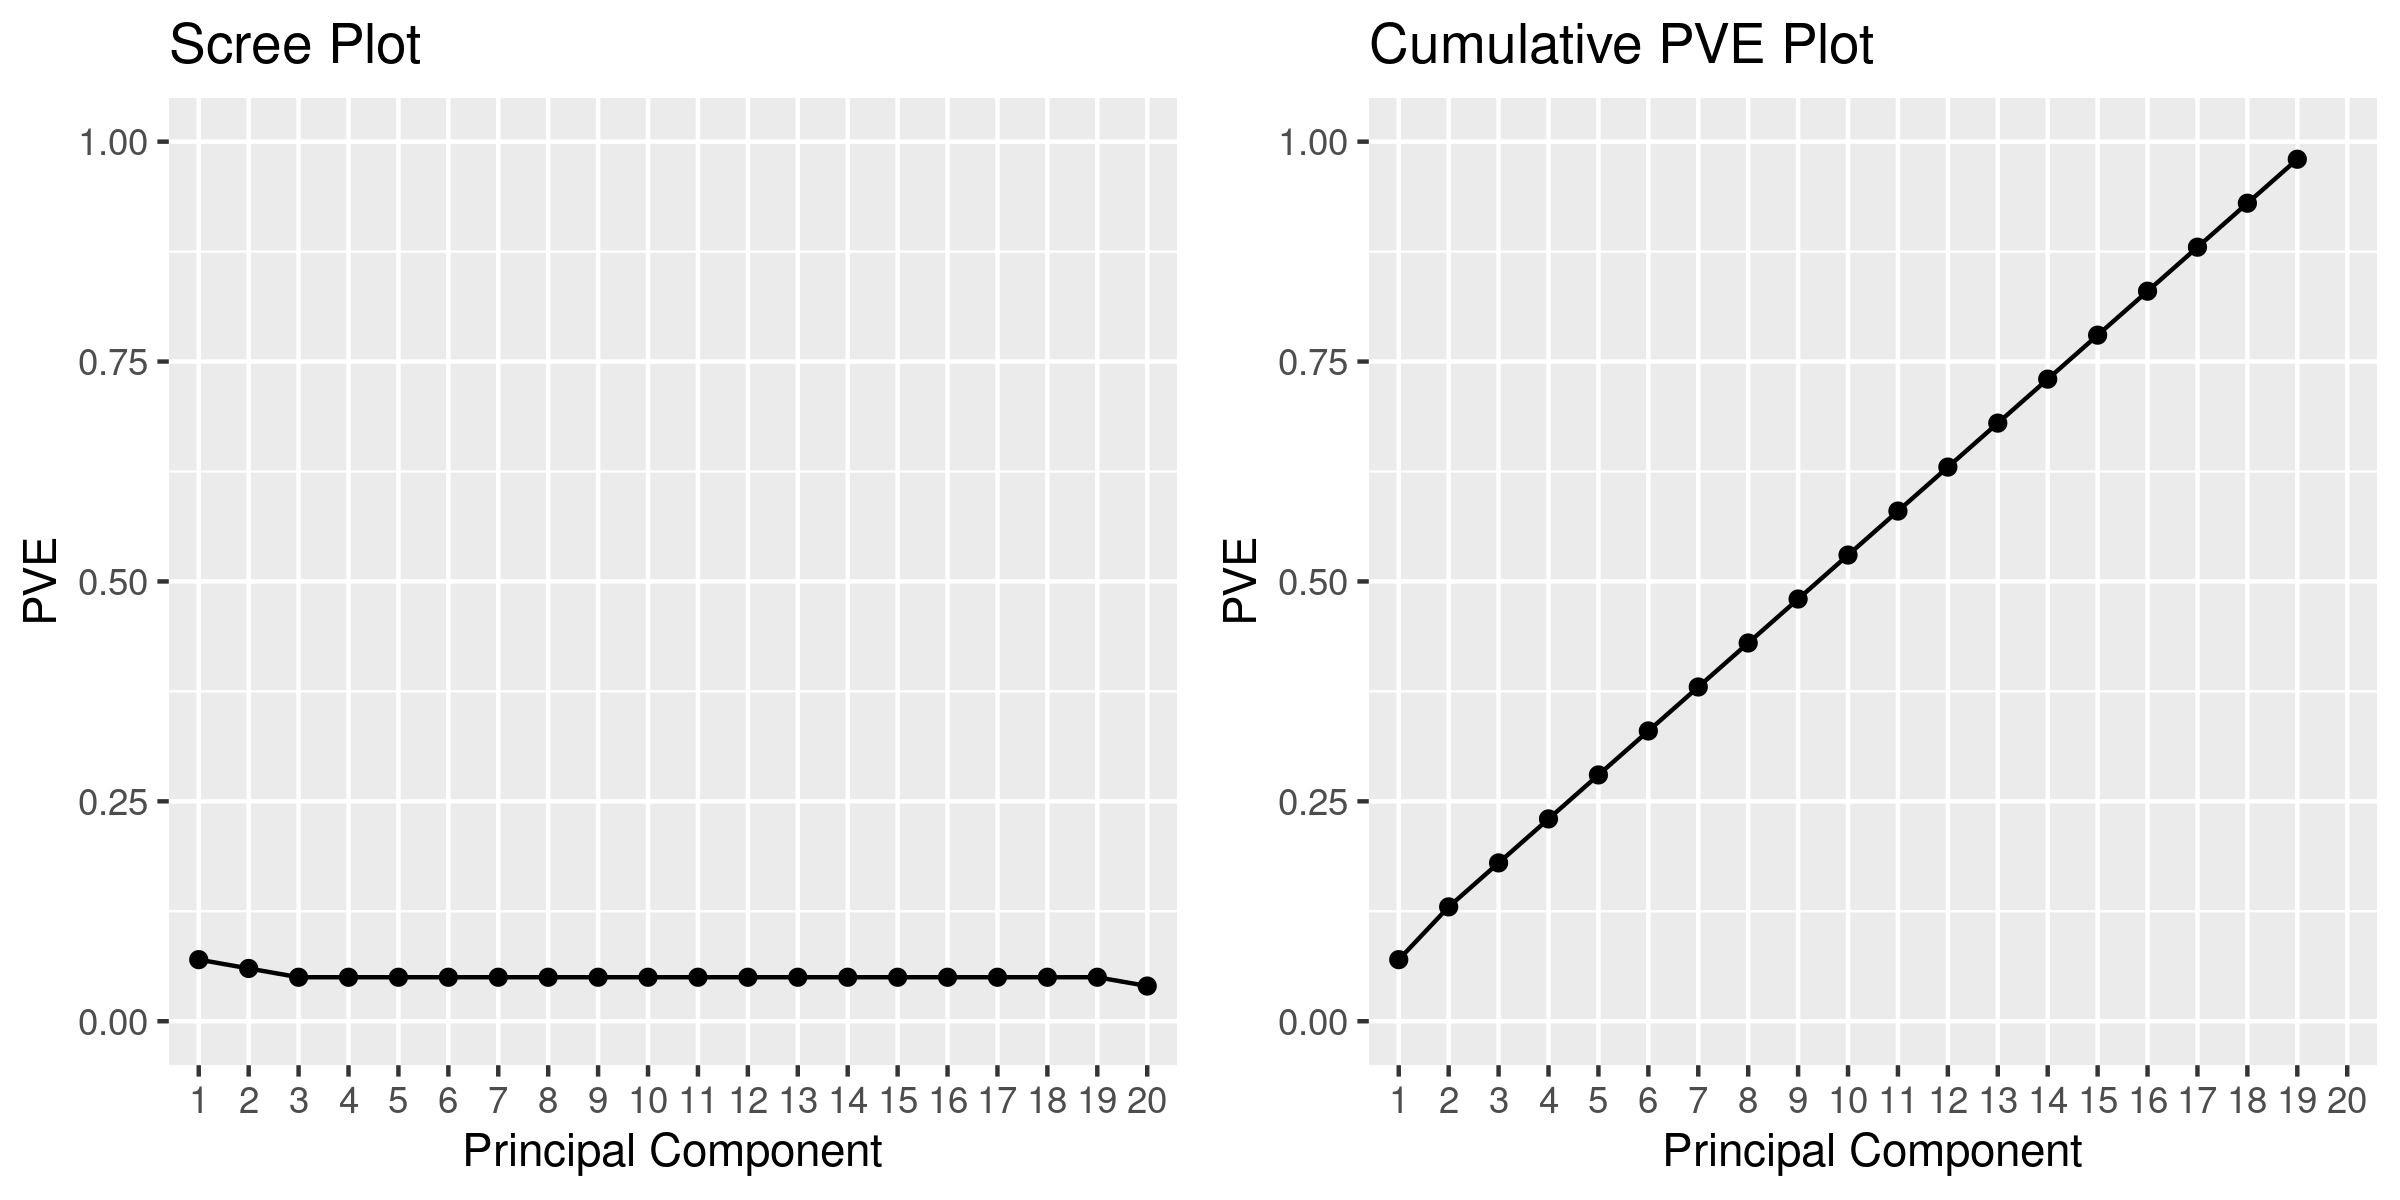

In [3]:
%preview ~/tmp/25-Jan-2022/output/pca/MWE_pheno.pca.scree.png

### Projection of related individuals

Same as above, if you have an ethnicity variable you can specify it by using `label_col` and here you would also need to add `pop_col` that points to the same variable. This is necessary, otherwise the detect_outliers part of the workflow will error. 


In [ ]:
```
sos run PCA.ipynb project_samples \
  --cwd output/pca \
  --genoFile output/rename_chr22.20220110.related.for_pca.filtered.extracted.bed \
  --phenoFile data/MWE_pheno.txt \
  --pca-model output/pca/MWE_pheno.pca.rds \
  --label-col RACE \
  --pop-col RACE \
  --maha-k 2 \
  --container container/flashpcaR.sif
```

> /home/gw/tmp/25-Jan-2022/output/pca/MWE_pheno.pca.projected.pc.png (570.8 KiB):

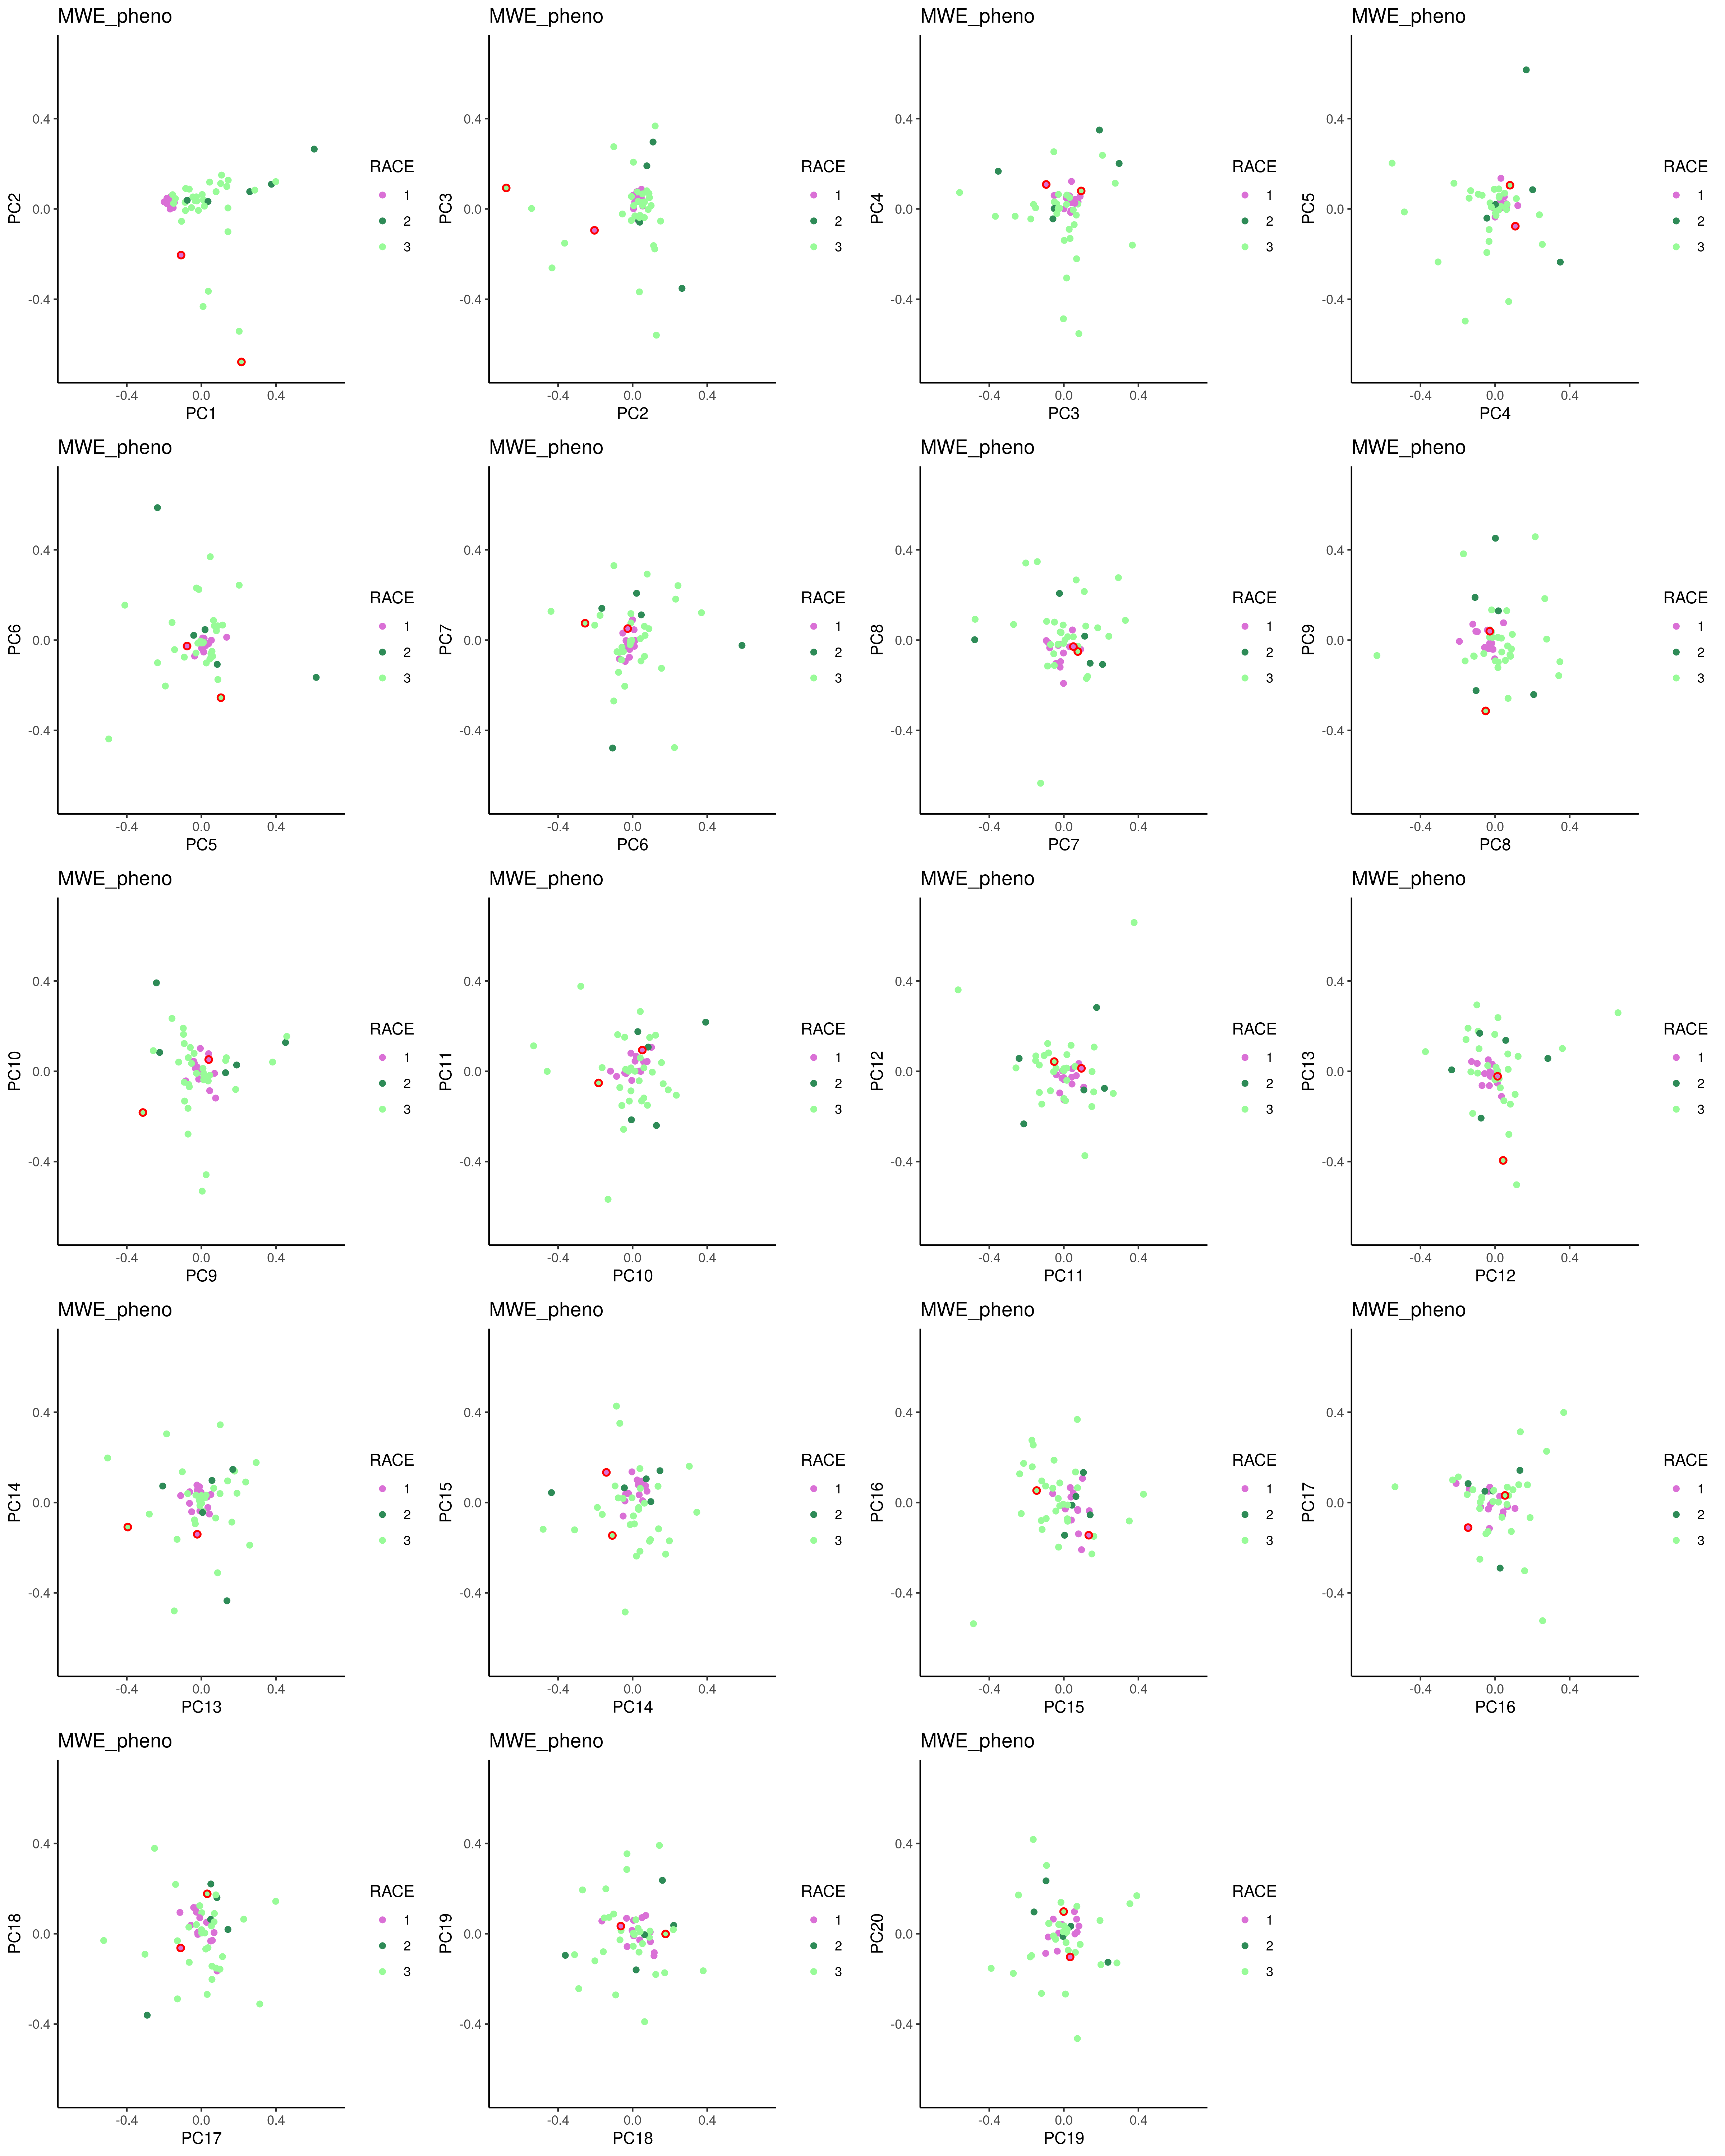

In [4]:
%preview ~/tmp/25-Jan-2022/output/pca/MWE_pheno.pca.projected.pc.png

### Finalize genotype QC by PCA for homogenous population

Now pretend you analyze a homogenous population and you only did PCA to remove PC outliers. You have decided the outliers to remove and you would like to finalize the genotype QC. 

First, remove these outliers and perform genotype data QC, similar to our initial QC but without LD pruning:

In [ ]:
sos run GWAS_QC.ipynb qc_no_prune \
    --cwd output \
    --genoFile output/rename_chr22.20220110.unrelated.bed \
    --remove-samples output/pca/MWE_pheno.pca.projected.outliers \
    --name no_outlier \
    --container container/bioinfo.sif

Also remove outliers and keep the same variant as unrelated individuals, in related individuals:

In [ ]:
sos run GWAS_QC.ipynb qc_no_prune \
    --cwd output \
    --genoFile output/rename_chr22.20220110.related.bed \
    --remove-samples output/pca/MWE_pheno.pca.projected.outliers \
    --keep-variants output/rename_chr22.20220110.unrelated.no_outlier.filtered.bim \
    --maf-filter 0 --geno-filter 0 --mind-filter 0.1 --hwe-filter 0 \
    --name no_outlier \
    --container container/bioinfo.sif

Finally, merge back related and unrelated individuals as finalized genotype in PLINK format,

In [ ]:
sos run genotype_formatting.ipynb merge_plink \
    --genoFile output/rename_chr22.20220110.unrelated.no_outlier.filtered.bed \
               output/rename_chr22.20220110.related.no_outlier.filtered.extracted.bed \
    --cwd output/genotype_final \
    --name chr22_20220110_qced \
    --container container/bioinfo.sif

You can stop here if you're analyzing a homogenous population.

### Split data by population

If your data contains multiple populations, then for each population, you can still use the `GWAS_QC.ipynb` and `PCA.ipynb` workflows, except that at this step you have to split data by population using manually created files to include or to remove samples.

In [ ]:
pheno = read.table("data/MWE_pheno.txt", header = TRUE, stringsAsFactors=F)
for (i in 1:3){
 race = subset(pheno, RACE == i)
 race_id = cbind(race[,2],race[, 2])
 write.table(race_id, paste0("output/ID.", "race", i), quote = FALSE, sep = '\t', col.names = FALSE, row.names = FALSE)
}

### For each population, do variant level and sample level QC on unrelated individuals, in preparation for PCA analysis

Below we perform analysis on each population. Here we only show it for Populations 1 and 3

In [ ]:
for i in race1 race3; do
    sos run GWAS_QC.ipynb qc \
        --cwd output \
        --genoFile output/rename_chr22.20220110.unrelated.bed \
        --keep-samples output/ID.$i \
        --name for_pca_$i \
        --container container/bioinfo.sif

### For each population, extract previously selected variants from related individuals in preparation for PCA, only applying missingness filter at sample level, if applicable

You will run into an error message for population 1, which you can find inside `ename_chr22.20220110.related.for_pca_race1.filtered.extracted.stderr` that says: `Error: No people remaining after --keep.`. That means there is no samples from population 1 among the related individuals. You can safely ignore this, and only handle related individuals for population 3 in upcoming analysis.

In [ ]:
for i in race1 race3; do
    sos run GWAS_QC.ipynb qc_no_prune \
        --cwd output \
        --genoFile output/rename_chr22.20220110.related.bed \
        --keep-variants output/rename_chr22.20220110.unrelated.for_pca_$i.filtered.prune.in \
        --keep-samples output/ID.$i \
        --maf-filter 0 --geno-filter 0 --mind-filter 0.1 --hwe-filter 0 \
        --name for_pca_$i \
        --container container/bioinfo.sif -s force

### For each population, run PCA analysis for unrelated samples

Set the partial PCA to 5 PCs because the sample size is too small to work with the default 20 PCs.

In [ ]:
for i in race1 race3; do
    sos run PCA.ipynb flashpca \
        --name $i \
        --cwd output/pca \
        --genoFile output/rename_chr22.20220110.unrelated.for_pca_$i.filtered.prune.bed \
        --phenoFile data/MWE_pheno.txt \
        --label-col RACE \
        --pop-col RACE \
        --maha-k 2 \
        --k 5 \
        --container container/flashpcaR.sif

### For each population, run projection of related individuals if applicable
Here we only do it for population 3 (there was no related individuals in population 1):

In [ ]:
for i in race3; do
    sos run PCA.ipynb project_samples \
      --name $i \
      --cwd output/pca \
      --genoFile output/rename_chr22.20220110.related.for_pca_$i.filtered.extracted.bed \
      --phenoFile data/MWE_pheno.txt \
      --pca-model output/pca/MWE_pheno.$i.pca.rds \
      --label-col RACE \
      --pop-col RACE \
      --maha-k 2 \
      --k 5 \
      --container container/flashpcaR.sif

To visualize the results at this point,

> /home/gw/tmp/19-Jan-2022/output/pca/MWE_pheno.race3.pca.projected.pc.png (124.0 KiB):

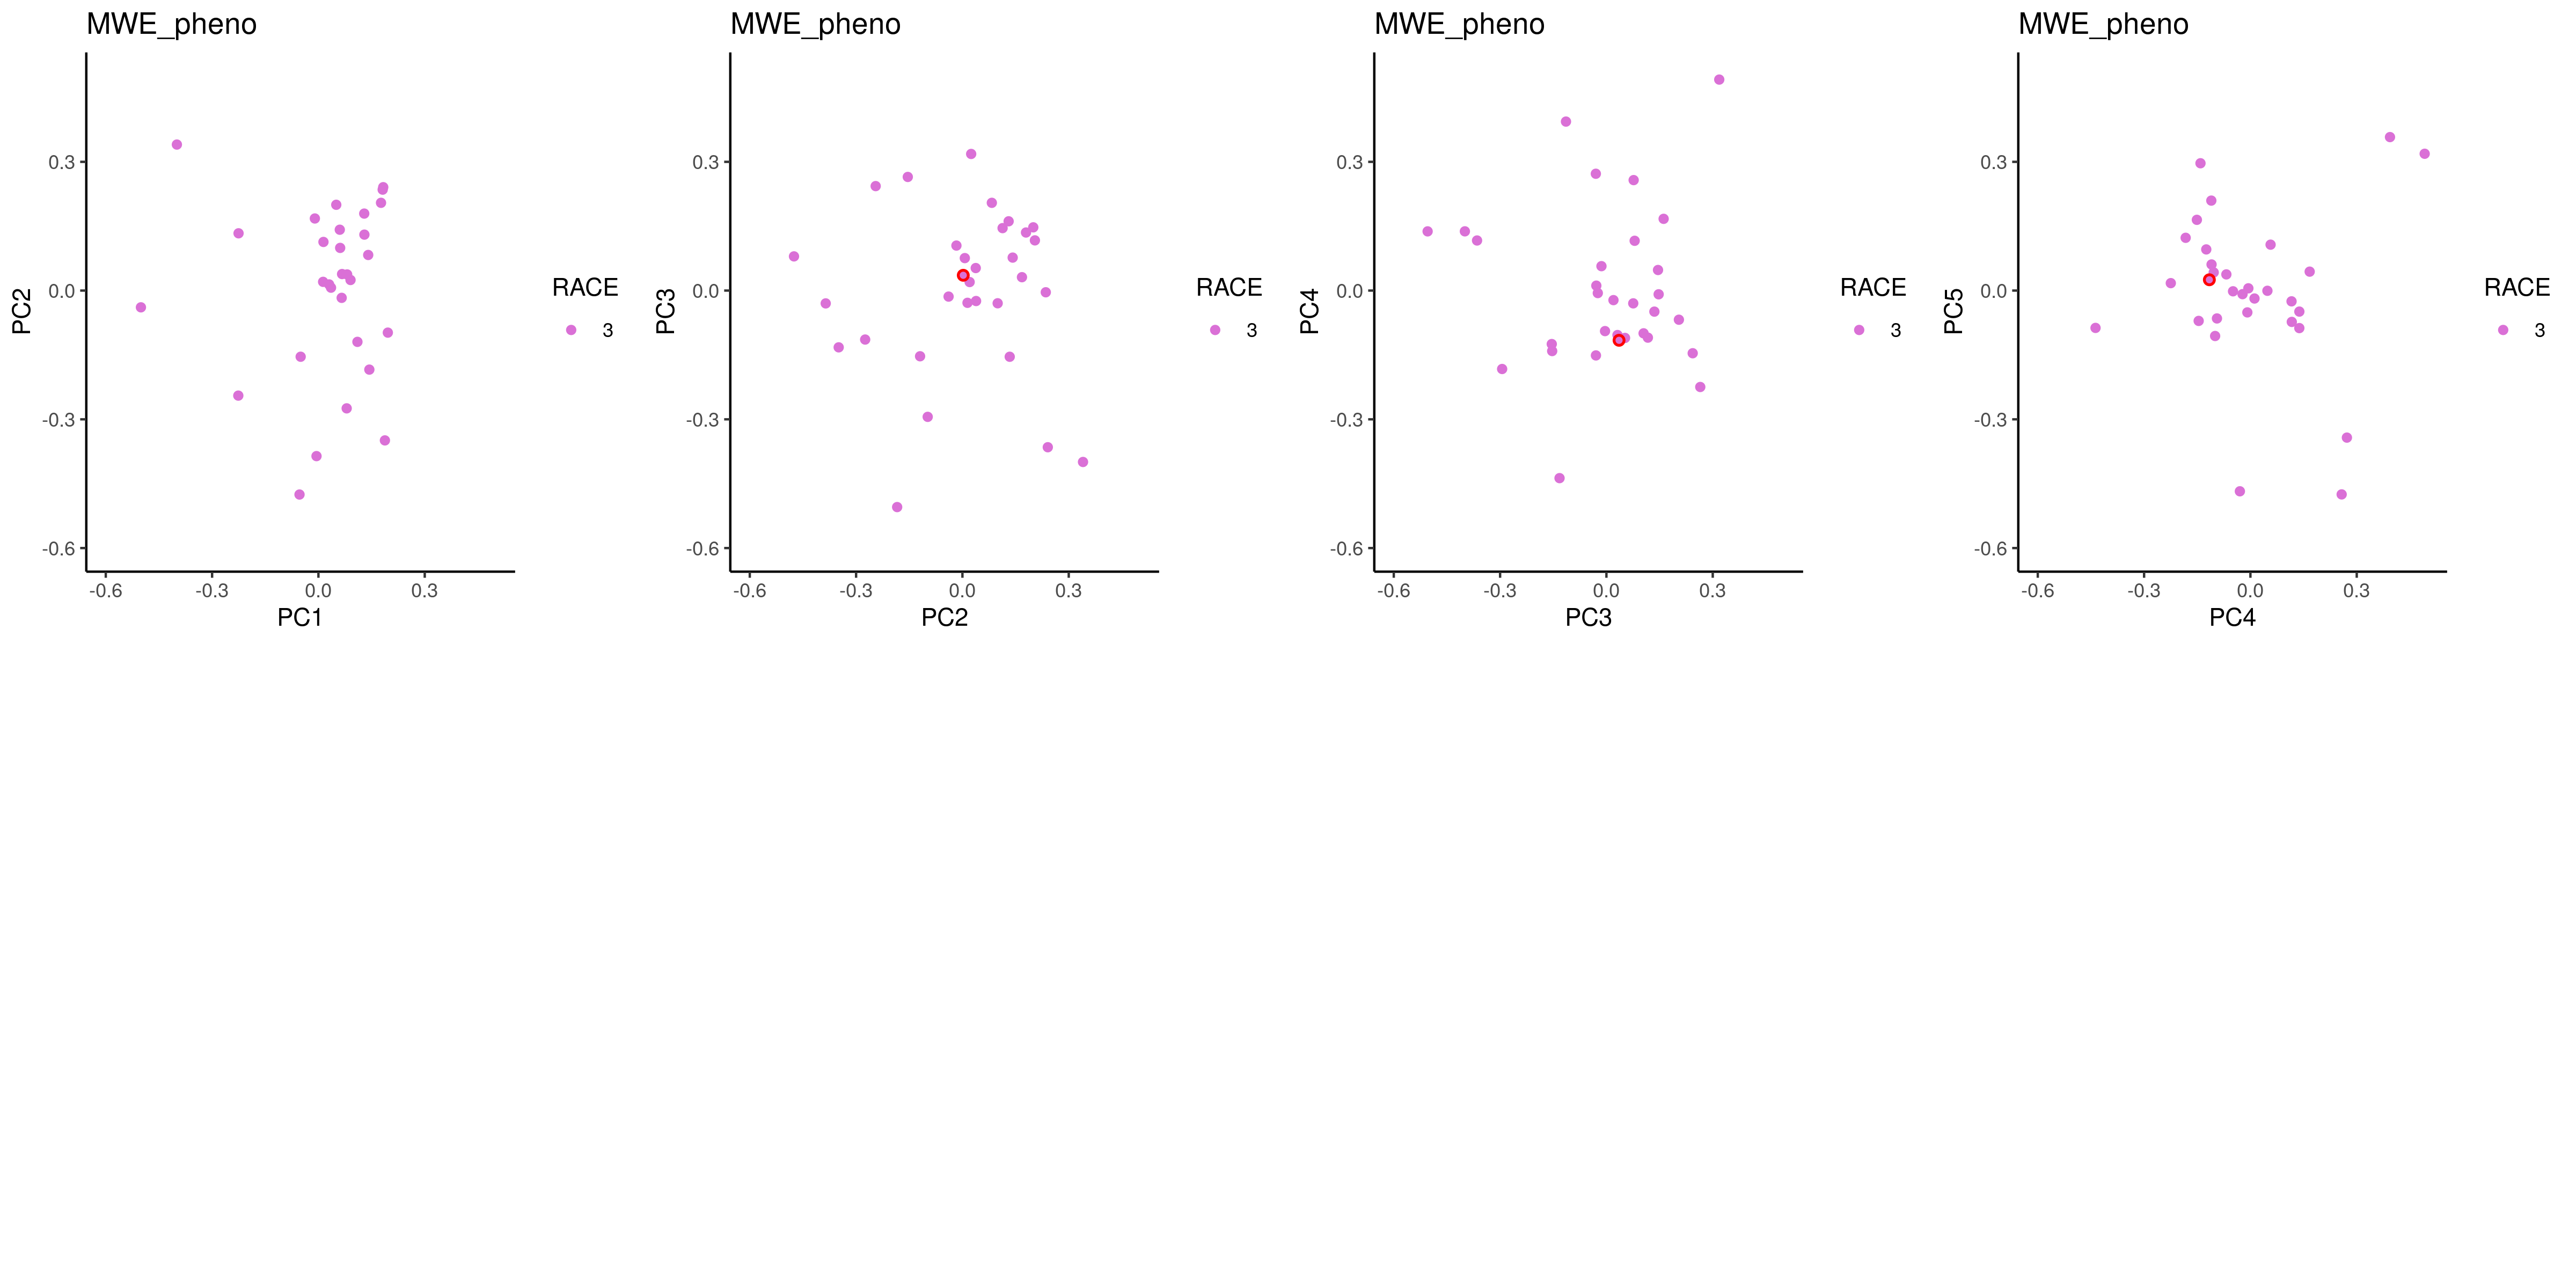

In [4]:
%preview ~/tmp/19-Jan-2022/output/pca/MWE_pheno.race3.pca.projected.pc.png 

### For each population do their own QC to finalize 

Same as steps as the **Finalize genotype QC by PCA for homogenous population** step, taking into consideration of outliers detected. Please read the `GWAS_QC.ipynb` document to see available QC options and recommendations.

## Command Interface

In [ ]:
sos run PCA.ipynb -h

In [ ]:
[global]
# the output directory for generated files
parameter: cwd = path("output")
# A string to identify your analysis run
parameter: name = ""
# Name of the population column in the phenoFile
parameter: pop_col = ""
# Name of the populations (from the population column) you would like to plot and show on the PCA plot
parameter: pops = []
# Name of the color label column in the phenoFile; can be the same as population column. Can also be a separate column eg a "super population" column as a way to enable you to combine selected populations based on another column.
parameter: label_col = ""
# Number of Principal Components to output,must be consistant between flashpca run and project samples run (flashpca partial PCA method).
parameter: k = 20
# Number of Principal Components based on which outliers should be evaluated. Default is 5 but this should be based on examine the scree plot
parameter: maha_k = 5
# Homogeneity of populations. Set to --homogeneous when true and --no-homogeneous when false
parameter: homogeneous = False
# Software container option
parameter: container = ""
import re
parameter: entrypoint= ('micromamba run -a "" -n' + ' ' + re.sub(r'(_apptainer:latest|_docker:latest|\.sif)$', '', container.split('/')[-1])) if container else ""
# For cluster jobs, number commands to run per job
parameter: job_size = 1
# Wall clock time expected
parameter: walltime = "5h"
# Memory expected
parameter: mem = "16G"
# Number of threads
parameter: numThreads = 10
suffix = '_'.join(pops)
cwd = path(f"{cwd:a}")
if not pop_col:
    homogeneous = True

In [ ]:
# PCA command with PLINK, as a sanity check
[pca_plink]
# PLINK binary file
parameter: genoFile = path
input: genoFile
output: f'{cwd}/{genoFile:bn}.pca.eigenvec'
task: trunk_workers = 1, trunk_size = job_size, walltime = walltime, mem = mem, cores = numThreads, tags = f'{step_name}_{_output[0]:bn}'
bash: container = container, expand = "${ }", stderr = f'{_output[0]:n}.stderr', stdout = f'{_output[0]:n}.stdout', entrypoint=entrypoint
    plink --bfile ${_input:n} --out ${_output:n} --pca ${k}

## PCA analysis

In [ ]:
# Run PCA analysis using flashpca 
[flashpca_1]
# Plink binary file
parameter: genoFile = path
# The phenotypic file
parameter: phenoFile = path(f'{genoFile}'.replace(".bed",".fam"))
# minimum population size to consider in the analysis
parameter: min_pop_size = 2
# How to standardize X before PCA
parameter: stand = "binom2"
## Input genoFile here is for unrelated samples
input: genoFile, phenoFile
output: f'{cwd}/{phenoFile:bn}{("."+name) if name else ""}.{(suffix+".") if suffix != "" else ""}pca.rds'
task: trunk_workers = 1, trunk_size = job_size, walltime = walltime, mem = mem, cores = numThreads, tags = f'{step_name}_{_output[0]:bn}'
R: container = container, expand = "${ }", stderr = f'{_output:n}.stderr', stdout = f'{_output:n}.stdout', entrypoint=entrypoint
    # Load required libraries
    library(flashpcaR)
    library(dplyr)
    pops = c(${paths(pops):r,})
    f <- flashpca(${_input[0]:nr}, ndim=${k}, stand="${stand}", do_loadings=TRUE, check_geno=TRUE)
    rownames(f$loadings) <- read.table('${_input[0]:n}.bim',stringsAsFactors =F)[,2]
    # Use the projection file to generate pca plot
    pca <- as.data.frame(f$projection)
    pca <- tibble::rownames_to_column(pca, "ID")
    colnames(pca) <- c("ID",paste0("PC", 1:${k}))
  
    # Read fam file with phenotypes
    if(stringr::str_detect(${_input[1]:r},".fam$")){
        pheno <- read.table(${_input[1]:r}, header=F,stringsAsFactors =F)
        colnames(pheno) = c("FID", "IID", "MID", "PID", "SEX", "STATUS")
    } else {
        pheno <- read.table(${_input[1]:r}, header=T,stringsAsFactors =F)
        if("IID" %in% colnames(pheno) == FALSE) stop("No IID column in the phenoFile. Please rename the header of the phenoFile")
        if("FID" %in% colnames(pheno) == FALSE) pheno$FID = pheno$IID
    }
    # Make the unique ID by merge FID and IID
    pheno$ID = paste(pheno$FID,pheno$IID,sep = ":")
    #check duplicated ID
    if(length(unique(pheno$ID))!=length(pheno$ID)) stop("There are duplicated names in IID column of phenoFile")

    if (length(pops)>0) pheno <- pheno %>%filter(${pop_col if pop_col else  "pop"} %in% pops | ${label_col if label_col else  "pop"} %in% pops)
    pca <-merge(pheno, pca,by ="ID", all=FALSE) 
    #
    if (${"TRUE" if pop_col else "FALSE"}) {
        # remove populations have less than ${min_pop_size} samples
        pop<-names(table(pca$${pop_col if pop_col else "pop"}))
        pop_filter<-pop[table(pca$pop)<${min_pop_size}] # pop to be removed
        if (length(pop_filter)>0) {
            warning(for (i in pop_filter){cat(i,';')},'these ', length(pop_filter)," population will be removed due to having less than ${min_pop_size} samples in data.")
            # remove
            pca<-pca%>% filter(${f'!{pop_col}%in%pop_filter' if pop_col else pop_col})
        }
    } else {
      pca$pop <- 1 
    }

    # Write the PC scores to a file
    write.table(pca,"${_output:n}.txt", sep="\t", quote=FALSE, row.names=FALSE, col.names=TRUE)
    dat = list(pca_model = f, pc_scores = pca, meta = "${_input[1]:bn} ${suffix}")
    # compute centroids before projecting back the samples
    # (calculate mean/median/cov per pop)
    if(${"FALSE" if homogeneous else "TRUE"}){
        pop_group <- split(dat$pc_scores[ ,c(paste0("PC", 1:${maha_k}))], list(Group = dat$pc_scores$${pop_col if pop_col else "pop"}))
        dat$pc_cov <- lapply(pop_group, function(x) cov(x))
        dat$pc_mean <- lapply(pop_group, function(x) sapply(x, mean))
        dat$pc_median <- lapply(pop_group, function(x) sapply(x, median))
    } else {
        dat$pc_cov <- cov(f$projection[,1:${maha_k}])
        dat$pc_mean <- apply(f$projection[,1:${maha_k}], 2, mean)
        dat$pc_median <- apply(f$projection[,1:${maha_k}], 2, median)
    }
  
    # save results
    saveRDS(dat, ${_output:r})
  
bash: expand= "$[ ]", stderr = f'{_output:n}.stderr', stdout = f'{_output:n}.stdout', container = container, entrypoint=entrypoint
        stdout=$[_output:n].stdout
        for i in $[_output] ; do 
        echo "output_info: $i " >> $stdout;
        echo "This rds file is a list containing the pca for unrelated sample" >> $stdout;
        echo "output_size:" `ls -lh $i | cut -f 5  -d  " "`   >> $stdout;
        done

## Project related individuals back

In [ ]:
# Project back to PCA model additional samples
[project_samples_1]
# Plink binary file
parameter: genoFile = path
# The phenotypic file
parameter: phenoFile = path(f'{genoFile}'.replace(".bed",".fam"))
parameter: pca_model = f'{cwd}/{phenoFile:bn}{("."+name) if name else ""}.{(suffix+".") if suffix != "" else ""}pca.rds'
## Input genoFile here is for related samples
input: genoFile, phenoFile, pca_model
output: f'{cwd}/{phenoFile:bn}{("."+name) if name else ""}.pca.projected.rds'
task: trunk_workers = 1, trunk_size = job_size, walltime = walltime, mem = mem, cores = numThreads, tags = f'{step_name}_{_output[0]:bn}'
R: container=container, expand= "${ }", stderr = f'{_output:n}.stderr', stdout = f'{_output:n}.stdout', entrypoint=entrypoint
    # Load required libraries
    library(dplyr)
    library(flashpcaR)
    # Read the PLINK binary files
    frel <- ${_input[0]:nr}
    # Read loadings, center and scale from previous PCA
    dat <- readRDS(${_input[2]:r})
    f <- dat$pca_model                           
    # Read the bim file to obtain reference alleles
    bim <- read.table('${_input[0]:n}.bim',stringsAsFactors =F)
    ref <- as.character(bim[,5])
    names(ref) <- bim[,2]
    if (nrow(f$loadings) != length(ref)) stop("Input number of variants should be the same as used in the previous PCA model")
    overlapped_variants <- match(names(ref), rownames(f$loadings))
    # Project related samples
    fpro <- project(frel, loadings=f$loadings[overlapped_variants,], orig_mean=f$center[overlapped_variants], orig_sd=f$scale[overlapped_variants], ref_allele=ref)
    pca <- fpro$projection
    k = ${k}
    pca <- as.data.frame(fpro$projection)
    pca <- tibble::rownames_to_column(pca, "ID")
    colnames(pca) <- c("ID",paste0("PC", 1:k))
    
    # Read fam file with phenotypes
    if(stringr::str_detect(${_input[1]:r},".fam$")){
        pheno <- read.table(${_input[1]:r}, header=F,stringsAsFactors =F)
        colnames(pheno) = c("FID", "IID", "MID", "PID", "SEX", "STATUS")
    } else {
        pheno <- read.table(${_input[1]:r}, header=T,stringsAsFactors =F)
        if("IID" %in% colnames(pheno) == FALSE) stop("No IID column in the phenoFile. Please rename the header of the phenoFile")
        if("FID" %in% colnames(pheno) == FALSE) pheno$FID = pheno$IID
    }
    # Make the unique ID by merge FID and IID
    pheno$ID = paste(pheno$FID,pheno$IID,sep = ":")
    #check duplicated ID
    if(length(unique(pheno$ID))!=length(pheno$ID)) stop("There are duplicated names in IID column of phenoFile")

    pca <-merge(pheno, pca,by ="ID", all=FALSE)
    dat$pc_scores = bind_rows(dat$pc_scores, pca)
    
    # Write the PC scores to a file
    write.table(dat$pc_scores,"${_output:n}.txt", sep="\t", quote=FALSE, row.names=FALSE, col.names=TRUE)
    # save results
    saveRDS(dat, ${_output:r})
  
bash: expand= "$[ ]", stderr = f'{_output:n}.stderr', stdout = f'{_output:n}.stdout', container = container, entrypoint=entrypoint
        stdout=$[_output:n].stdout
        for i in $[_output] ; do 
        echo "output_info: $i " >> $stdout;
        echo "This rds file is a list containing the pca for projected sample" >> $stdout;
        echo "output_size:" `ls -lh $i | cut -f 5  -d  " "`   >> $stdout;
        done
        for i in $[_output:n].txt ; do 
        echo "output_info $i " >> $stdout;
        echo "This is the PC score" >> $stdout;
        echo "output_size:" `ls -lh $i | cut -f 5  -d  " "`   >> $stdout;
        echo "output_rows:" `cat $i | wc -l  | cut -f 1 -d " "`   >> $stdout;
        echo "output_column:" `cat $i | head -1 | wc -w `   >> $stdout;
        echo "output_preview:"   >> $stdout;
        cat $i | head  | cut -f 1,2,3,4,5,6   >> $stdout ; done

## Plot PCA results


In [ ]:
# Plot PCA results. 
# Can be used independently as "plot_pca" or combined with other workflow as eg "flashpca+plot_pca"
[plot_pca]
parameter: outlier_file = path()
parameter: plot_data = path
parameter: min_axis = ""
parameter: max_axis = ""
input: plot_data
output: f'{cwd}/{_input:bn}.pc.png',
        f'{cwd}/{_input:bn}.scree.png',
        f'{cwd}/{_input:bn}.scree.txt'
task: trunk_workers = 1, trunk_size = job_size, walltime = walltime, mem = mem, cores = 1, tags = f'{step_name}_{_output[0]:bn}'
R: container = container, volumes = [f"{outlier_file:ad}:{outlier_file:ad}"], expand = "${ }", stderr = f'{_output[0]:n}.stderr', stdout = f'{_output[0]:n}.stdout', entrypoint=entrypoint
    library(dplyr)
    library(ggplot2)
    library(gridExtra)
    library(matrixStats)
    pops = c(${paths(pops):r,})
    dat = readRDS(${_input:r})
    f = dat$pca_model
    pca_final<-dat$pc_scores
    
    if (length(pops)>1) pca_final <- pca_final %>% filter(${pop_col if pop_col else "pop"} %in% pops | ${label_col if label_col else  "pop"} %in% pops) 
    pca_final <- pca_final %>% mutate(${label_col if label_col else "pop"}=as.character(${label_col if label_col else  "pop"}))
    k = ${k}
    # manually set colors for PCA plotting, to avoid similar colors in one plot:
    # generated by https://mokole.com/palette.html
    set.seed(999)
    colors_40 = sample(c("#a9a9a9", "#2f4f4f", "#556b2f", "#a0522d", "#7f0000", "#006400", "#808000", "#483d8b", "#3cb371", "#bdb76b", "#4682b4", "#9acd32", 
                          "#20b2aa", "#00008b", "#32cd32", "#daa520", "#7f007f", "#b03060", "#ff0000", "#ff8c00", "#ffff00", "#0000cd", "#00ff00", "#9400d3", 
                          "#00fa9a", "#00ffff", "#00bfff", "#f4a460", "#f08080", "#adff2f", "#ff6347", "#ff00ff", "#1e90ff", "#dda0dd", "#7b68ee", "#afeeee", 
                          "#ee82ee", "#ff69b4", "#ffe4c4", "#ffc0cb"))
    colors_20 = sample(c("#2f4f4f", "#2e8b57", "#8b0000", "#808000", "#00008b", "#ff0000", "#ff8c00", "#00ff00", "#4169e1", "#00ffff", "#00bfff", "#0000ff", 
                          "#da70d6", "#d8bfd8", "#ff00ff", "#eee8aa", "#ffff54", "#ff1493", "#ffa07a", "#98fb98"))

    # assign colors to each ethnicity:
    num_col=length(unique(pca_final$${label_col if label_col else "pop"}))
    if (num_col <= 20) {
       color_list <- colors_20[1:num_col]
    } else {
       color_list <- colors_40[1:num_col]
    }

    ###
    # Make the plots
    ###
    # Get the min and max values for x and y-axes
    if (${"TRUE" if len(min_axis) == 0 or len(max_axis) == 0 else "FALSE"}) {
        min_axis <- round(colMins(as.matrix(f$projection[sapply(f$projection, is.numeric)])),1)
        max_axis <- round(colMaxs(as.matrix(f$projection[sapply(f$projection, is.numeric)])),1)  
    } else {
        min_axis <- as.double(${min_axis})
        max_axis <- as.double(${max_axis})
    }
    if (${"TRUE" if outlier_file.is_file() else "FALSE"}) {
        outliers <- read.table(${outlier_file:r}, col.names=c("FID", "IID"),stringsAsFactors =F)
        plot_pcs = function(pca_final, x, y, title="") {
            ggplot(pca_final, aes_string(x=x, y=y)) + geom_point(${f'aes(color={label_col})' if label_col else ""}) + 
              # add circles for these ouliters:
              geom_point(data=filter(pca_final, IID %in% outliers$IID, FID %in% outliers$FID), shape = 21, size=1.5, color='red', stroke = 0.9) +
              # add outliers dots:
              geom_point(data=filter(pca_final, IID %in% outliers$IID, FID %in% outliers$FID), shape = 16, size=1${f',aes(color={label_col})' if label_col else ""} ) + 
              labs(title=title,x=x, y=y) +
              scale_y_continuous(limits=c(min_axis, max_axis)) +
              scale_x_continuous(limits=c(min_axis, max_axis)) +
              scale_color_manual(values=color_list) +
              theme_classic()
        }} else {
        plot_pcs = function(pca_final, x, y, title="") {
          ggplot(pca_final, aes_string(x=x, y=y)) + geom_point(${f'aes(color={label_col})' if label_col else ""}) + 
              labs(title=title,x=x, y=y) +
              scale_y_continuous(limits=c(min_axis, max_axis)) +
              scale_x_continuous(limits=c(min_axis, max_axis)) +
              scale_color_manual(values=color_list) +
              theme_classic()
        }}
    unit = 4
    n_col = min(4, k)
    n_row = ceiling(k / n_col)
    plots = lapply(1:(k-1), function(i) plot_pcs(pca_final, paste0("PC",i), paste0("PC",i+1), dat$meta))
    png('${_output[0]}', width = unit * n_col, height = unit * n_row, unit='in', res=300)
    do.call(gridExtra::grid.arrange, c(plots, list(ncol = n_col, nrow = n_row)))
    dev.off()
    # Create scree plot
    PVE <- f$values
    PVE <- round(PVE/sum(PVE), 2)
    PVEplot <- qplot(c(1:length(PVE)), PVE) + geom_line() + xlab("Principal Component") + ylab("PVE") + ggtitle("Scree Plot") + ylim(0, 1) +scale_x_discrete(limits=factor(1:length(PVE)))
    PVE_cum <- cumsum(PVE)/sum(PVE)
    cumPVEplot <- qplot(c(1:length(PVE)), cumsum(PVE)) + geom_line() + xlab("Principal Component") + ylab("PVE") + ggtitle("Cumulative PVE Plot") + ylim(0, 1) + scale_x_discrete(limits=factor(1:length(PVE)))
    png('${_output[1]}', width = 8, height = 4, unit='in', res=300)
    grid.arrange(PVEplot, cumPVEplot, nrow = 1)
    dev.off()
    ## Textual Output
    
    PVE_output = tibble(PCs = 1:length(PVE), PVE = PVE, PVE_cum = PVE_cum )
    PVE_output%>%readr::write_delim(${_output[2]:r},"\t")

bash: expand= "$[ ]", stderr = f'{_output[0]:n}.stderr', stdout = f'{_output[0]:n}.stdout' , container = container, entrypoint=entrypoint
        stdout=$[_output[0]:n].stdout
        for i in $[_output[2]] ; do 
        echo "output_info $i " >> $stdout;
        echo "This is the PC score" >> $stdout;
        echo "output_size:" `ls -lh $i | cut -f 5  -d  " "`   >> $stdout;
        echo "output_rows:" `cat $i | wc -l  | cut -f 1 -d " "`   >> $stdout;
        echo "output_column:" `cat $i | head -1 | wc -w `   >> $stdout;
        echo "output_preview:"   >> $stdout;
        cat $i | head  | cut -f 1,2,3,4,5,6   >> $stdout ; done

## Detect outliers

In [ ]:
# Calculate Mahalanobis distance per population and report outliers
[detect_outliers]
# Set the probability to remove outliers eg 0.95 or 0.997
parameter: prob = 0.997
# Mahalanobis distance p-value cutoff
parameter: pval = 0.05
# Robust Mahalanobis to outliers
parameter: robust = True
parameter: pca_result = path
input: pca_result
output: distance=f'{_input:n}.mahalanobis.rds',
        identified_outliers=f'{_input:n}.outliers',
        analysis_summary=f'{_input:n}.analysis_summary.md',
        qqplot_mahalanobis=f'{_input:n}.mahalanobis_qq.png',
        hist_mahalanobis=f'{_input:n}.mahalanobis_hist.png'
task: trunk_workers = 1, trunk_size = job_size, walltime = walltime, mem = mem, cores = 1, tags = f'{step_name}_{_output[0]:bn}'
bash: container = container, expand = "${ }", entrypoint=entrypoint
    echo '''---
    theme: base-theme
    style: |
      img {
        height: 80%;
        display: block;
        margin-left: auto;
        margin-right: auto;
      }
    ---    
    ''' > ${_output[2]}
    
R: container = container, expand= "${ }", stderr = f'{_output[0]:n}.stderr', stdout = f'{_output[0]:n}.stdout', entrypoint=entrypoint
    # Load required libraries
    library(dplyr)
    library(ggplot2)
    library(gridExtra)
  
    # invert a known covariance matrix but allow them to be numerically singular matrix (still assuming full rank)
    robust_inv = function(s) {
        #tryCatch(solve(s), error=function(cond) solve(Matrix::nearPD(s)$mat))
        tryCatch(solve(s), error=function(cond) MASS::ginv(s))
    }

    # Calculate mahalanobis distance  
    calc_mahalanobis_dist = function(x, m, s, name = '', prob=${prob}) {
        pc <- x %>%
          select("IID","FID", "${pop_col if pop_col else "pop"}", starts_with("PC"))
        mu_pc <- pc[,4:(4 + length(m) - 1)]
        pc$mahal = mahalanobis(mu_pc, m, robust_inv(s), inverted=TRUE)
        pc$p <- pchisq(pc$mahal, df=nrow(s), lower.tail=FALSE)
        manh_dis_sq_cutoff = quantile(pc$mahal, probs=prob)
        # Obtain outliers
        outliers = pc[(pc$mahal > manh_dis_sq_cutoff & pc$p < ${pval}),]
        d_summary = paste0(capture.output(summary(pc$mahal)), collapse = '\n')
        msg = paste('#', name, "result summary\n## Mahalanobis distance summary:\n```\n", d_summary, "\n```\n", 
            paste("The cut-off for outlier removal is set to:", manh_dis_sq_cutoff, "and the number of individuals to remove is:", nrow(outliers),"\n"),
            paste("The new sample size after outlier removal is:",nrow(pc) - nrow(outliers),"\n"))
        #
        outliers <- outliers %>%
        select(FID,IID)
      list(pc=pc, manh_dis_sq_cutoff=manh_dis_sq_cutoff, msg=msg, outliers=outliers)
    }

    dat = readRDS(${_input:r})
    if (is.list(dat$pc_mean)) {
      pops = names(dat$pc_mean)
      pop_group = split(dat$pc_scores, f = dat$pc_scores$${pop_col if pop_col else "pop"})
      res = lapply(pops, function(p) calc_mahalanobis_dist(pop_group[[p]], dat$${"pc_mean" if not robust else "pc_median"}[[p]], dat$pc_cov[[p]], name = paste(dat$meta, p)))
      names(res) = pops
      res = list(
          msg = do.call(paste, c(lapply(pops, function(p) res[[p]]$msg), sep = "\n")),
          manh_dis_sq_cutoff = cbind(pops, sapply(pops, function(p) res[[p]]$manh_dis_sq_cutoff)),
          outliers = do.call(rbind, c(lapply(pops, function(p) res[[p]]$outliers))),
          pc = do.call(rbind, c(lapply(pops, function(p) res[[p]]$pc)))
          )
    } else {
      res = calc_mahalanobis_dist(dat$pc_scores, dat$${"pc_mean" if not robust else "pc_median"}, dat$pc_cov, name = dat$meta)
    }
      
    write(res$msg, ${_output[2]:r})   
    # Plot mahalanobis
    k = ${k}
    png('${_output[3]}', width = 4, height = 4, unit='in', res=300)
    qqplot(qchisq(ppoints(100), df=k), res$pc$mahal, main = expression("Mahalanobis" * ~D^2 * " vs. quantiles of" * ~ chi[k]^2), xlab = expression(chi[2]^2 * ", probability points = 100"), ylab = expression(D^2), pch=16)
    abline(0,1,col='red')
    dev.off() 
    png('${_output[4]}', width = 4, height = 4, unit='in', res=300)
    ggplot(res$pc, aes(x=mahal)) + geom_histogram(aes(y = ..count..), binwidth = 0.5, colour = "#1F3552", fill = "#4271AE") + scale_x_continuous(name = "Mahalanobis distance") + theme_classic()
    dev.off()
  
    # Save results and outliers
    saveRDS(res,${_output[0]:r})
    write.table(res$outliers, ${_output[1]:r}, sep="\t", quote=FALSE, row.names=FALSE, col.names=FALSE)
  
bash: expand= "$[ ]", stderr = f'{_output[0]:n}.stderr', stdout = f'{_output[0]:n}.stdout', container = container, entrypoint=entrypoint
        stdout=$[_output[0]:n].stdout
        for i in $[_output[0]] ; do 
        echo "output_info: $i " >> $stdout;
        echo "This rds file detail analysis output for detect outliers" >> $stdout;
        echo "output_size:" `ls -lh $i | cut -f 5  -d  " "`   >> $stdout;
        done
        for i in $[_output[1]] ; do 
        echo "output_info: $i " >> $stdout;
        echo "This text file documents the outliers samples" >> $stdout;
        echo "output_size:" `ls -lh $i | cut -f 5  -d  " "`   >> $stdout;
        done
        for i in $[_output[2]] ; do 
        echo "output_info: $i " >> $stdout;
        echo "This text file documents the analysis summary" >> $stdout;
        echo "output_size:" `ls -lh $i | cut -f 5  -d  " "`   >> $stdout;
        done
        for i in $[_output[3]] ; do 
        echo "output_info: $i " >> $stdout;
        echo "This plot documents the mahalanobis analysis result" >> $stdout;
        echo "output_size:" `ls -lh $i | cut -f 5  -d  " "`   >> $stdout; 
        done
        for i in $[_output[4]] ; do 
        echo "output_info: $i " >> $stdout;
        echo "This plot documents the mahalanobis distribution result" >> $stdout;
        echo "output_size:" `ls -lh $i | cut -f 5  -d  " "`   >> $stdout;
        done

## Add plot and outlier detection to PCA steps

In [ ]:
[flashpca_2, project_samples_2]
# Set the probability to remove outliers eg 0.95 or 0.997
parameter: prob = 0.997
# Robust Mahalanobis to outliers
parameter: robust = True
output: distance=f'{_input:n}.mahalanobis.rds',
        identified_outliers=f'{_input:n}.outliers',
        analysis_summary=f'{_input:n}.analysis_summary.md',
        qqplot_mahalanobis=f'{_input:n}.mahalanobis_qq.png',
        hist_mahalanobis=f'{_input:n}.mahalanobis_hist.png'
sos_run("detect_outliers", pca_result=_input, prob=prob, robust=robust)

[flashpca_3, project_samples_3]
input: output_from(1), output_from(2)['identified_outliers']
outliers = [x.strip() for x in open(_input[1]).readlines() if x.strip()]
output: f"{cwd}/{_input[0]:bn}.pc.png",
        f"{cwd}/{_input[0]:bn}.scree.png"
sos_run("plot_pca", plot_data = _input[0], outlier_file = _input[1] if len(outliers) else path())